In [1]:
from autoencodeSVJ import utils, models, trainer
import glob
import os
import numpy as np
import keras
import keras.backend as K
import matplotlib.pyplot as plt
# import root_numpy as rtnp

version_id = 'v1'
SEED = 42

Using TensorFlow backend.


### 1: load and normalize input data
we can use the data_loader for this. 
add an h5 sample, grab the table which represents it, and then split the table into training and testing datasets:

In [2]:
# get h5 datasets
data_path = "data/background/*_data.h5"
signal_path = "data/signal/*_data.h5"

data, data_tags, data_jets = utils.load_all_data(data_path, "background")
signal, signal_tags, signal_jets = utils.load_all_data(signal_path, "signal")

split = 0.25

train, test = data.train_test_split(split, SEED)
utils.compare_tags([train, test, data, signal])

data_raw = data.cdrop("*Flavor")
signal_raw = signal.cdrop("*Flavor")
train_raw = train.cdrop("*Flavor")
test_raw = test.cdrop("*Flavor")

norm_args = {"norm_type": "StandardScaler"}
train_norm, test_norm = train_raw.norm(train_raw, **norm_args), train_raw.norm(test_raw, **norm_args)
data_norm, signal_norm = train_raw.norm(data_raw, **norm_args), train_raw.norm(signal_raw, **norm_args)

background tags:

down jet: 18999, 18.4%
up jet: 38841, 37.6%
strange jet: 25377, 24.5%
charm jet: 9577, 9.3%
bottom jet: 3341, 3.2%
gluon jet: 7281, 7.0%

signal tags:

down jet: 1220, 2.5%
up jet: 1866, 3.8%
strange jet: 1550, 3.1%
charm jet: 3344, 6.8%
bottom jet: 38995, 78.8%
gluon jet: 2541, 5.1%

bottom:
	3.2% (2504) train
	3.2% (837) test
	3.2% (3341) background
	78.8% (38995) signal
up:
	37.4% (29023) train
	38.0% (9818) test
	37.6% (38841) background
	3.8% (1866) signal
down:
	18.4% (14251) train
	18.4% (4748) test
	18.4% (18999) background
	2.5% (1220) signal
strange:
	24.7% (19123) train
	24.2% (6254) test
	24.5% (25377) background
	3.1% (1550) signal
charm:
	9.2% (7151) train
	9.4% (2426) test
	9.3% (9577) background
	6.8% (3344) signal
gluon:
	7.1% (5510) train
	6.9% (1771) test
	7.0% (7281) background
	5.1% (2541) signal


data_table :: plotting distrubution(s) for table(s) ['jet 0 background', 'jet 1 background', 'jet 0 signal', 'jet 1 signal']


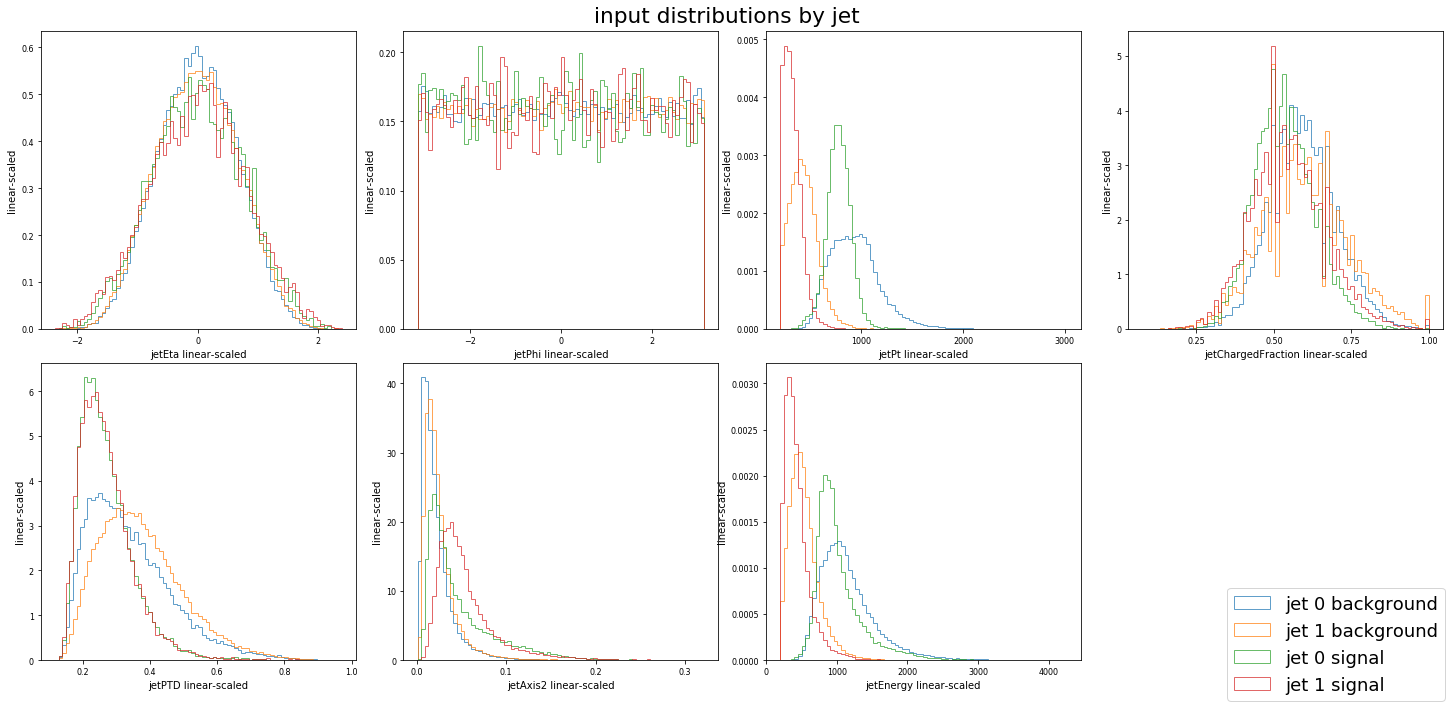

In [6]:
data_jets_raw = [d.cfilter(data_raw.headers) for d in data_jets]
signal_jets_raw = [d.cfilter(data_raw.headers) for d in signal_jets]

data_jets_raw[0].plot(data_jets_raw[1:] + signal_jets_raw, normed=1, figname="input distributions by jet", bins=80, figsize=20)

In [18]:
l1_amount = None          # l1 regularization amount
# KL_loss_weight = 1.8      # according to olmo's paper
input_dim = 7              # num. HLF
interm_dim = 50            # num. interm nodes
neck_dim = 3              # num. latent variables
kernel_max_norm = None     # kernel max norm amount
learning_rate = 0.001

name = "custom_loss_{0}_{1}".format(neck_dim, version_id)
repo_head = utils.get_repo_info()['head']
model_path = repo_head + "/autoencode/data/training_runs/"

### 2. build model 
To make our model, we'll use the simple "shallow" architecture defined in models.py. This gives us a decidedly shallow autoencoder with a bottleneck of our liking.

In [83]:
def ISRLU(args, min_value = 5e-3):
    """ranges from (0, +inf), with relu behavior at x > 0 and exponential decay at x < 0 (stolen from Olmo)"""
    return 1. + min_value + K.tf.where(K.tf.greater(args, 0), args, K.tf.divide(args, K.sqrt(1+K.square(args))))

class loss_layer(keras.layers.Layer):
    """Wrapper for recon. prob. function. 
    Outputs reconstruction probability of gaussians for vae
    """
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(loss_layer, self).__init__(**kwargs)
    
    def call(self, inputs):
        x, mu, sigma = inputs
        return reconstruction_probability(x, mu, sigma)

def reconstruction_probability(x, mu, sigma):
    """calculate gaussian -log likelihood across all variables and sum"""
    z_score = K.tf.divide(x - mu, sigma)
    single = - K.log(1./(sigma*np.sqrt(2.*np.pi)))/np.log(np.e) + 0.5*K.square(z_score)
    return K.sum(single, axis=-1)

def identity(y_train, vae_output):
    """identity loss, takes into account ONLY the VAE output (vae output should actually be the 
    calculated loss functions!)"""
    return K.mean(vae_output)

def sum_of_gaussians(x, mu_vec, sigma_vec):
    x = np.atleast_2d(x)
    if x.shape[0] <= x.shape[1]:
        x = x.T
    x_norm = (x - mu_vec)/sigma_vec
    single_gaus_val = np.exp(-0.5*np.square(x_norm))/(sigma_vec*np.sqrt(2*np.pi))
    return np.sum(single_gaus_val, axis=1)/mu_vec.shape[0]

custom_objects = {
    "ISRLU": ISRLU,
    "loss_layer": loss_layer,
    "reconstruction_probability": reconstruction_probability,
    "identity": identity,
    "sum_of_gaussians": sum_of_gaussians,
}

In [84]:
input_layer = keras.layers.Input(shape=(input_dim,), name="input")

intermediate_layer_enc1 = keras.layers.Dense(interm_dim, name="hidden_enc_1")
intermediate_layer_enc2 = keras.layers.Dense(interm_dim, activation='relu', kernel_constraint=keras.constraints.max_norm(kernel_max_norm), name='hidden_enc_2')

neck_layer = keras.layers.Dense(neck_dim, name='neck')
neck_input_layer = keras.layers.Input(shape=(neck_dim,), name='neck_input')

intermediate_layer_dec1 = keras.layers.Dense(interm_dim, activation='relu', name="hidden_dec_1", kernel_constraint=keras.constraints.max_norm(kernel_max_norm))
intermediate_layer_dec2 = keras.layers.Dense(interm_dim, activation='relu', name="hidden_dec_2")

output_sigma_pre_layer = keras.layers.Dense(input_dim, name="output_sigma_pre", activation="linear")
output_sigma_layer = keras.layers.Lambda(ISRLU, name="output_sigma")
output_mu_layer = keras.layers.Dense(input_dim, name="output_mu", activation="linear")

In [20]:
enc = intermediate_layer_enc1(input_layer)
enc = intermediate_layer_enc2(enc)
neck = neck_layer(enc)

dec = intermediate_layer_dec1(neck_input_layer)
dec = intermediate_layer_dec2(dec)

output_sigma = output_sigma_layer(output_sigma_pre_layer(dec))
output_mu = output_mu_layer(dec)

encoder = keras.models.Model(inputs=input_layer, outputs=neck, name='encoder')
decoder = keras.models.Model(inputs=neck_input_layer, outputs=[output_mu, output_sigma], name='decoder')
autoencoder = keras.models.Model(inputs=input_layer, outputs=decoder(encoder(input_layer)), name='autoencoder')

loss_output = loss_layer(name="loss_layer")([input_layer] + autoencoder(input_layer))
autoencoder_train = keras.models.Model(inputs=input_layer, outputs=loss_output, name='trae')

autoencoder_train.compile(
    optimizer=keras.optimizers.adam(lr=learning_rate),
    loss=[identity],
    loss_weights=[1.]
)
autoencoder_train.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 7)            0                                            
__________________________________________________________________________________________________
autoencoder (Model)             [(None, 7), (None, 7 6567        input[0][0]                      
__________________________________________________________________________________________________
loss_layer (loss_layer)         [(None, 7), (None, 7 0           input[0][0]                      
                                                                 autoencoder[1][0]                
                                                                 autoencoder[1][1]                
Total params: 6,567
Trainable params: 6,567
Non-trainable params: 0
_________________________________________

In [21]:
instance = trainer.trainer(os.path.join(model_path, name))

h5_elt 'metric_names' :: loading dataset 'data/metric_names' from file 'custom_loss_3_v1.h5'
h5_elt 'training' :: loading dataset 'params/training' from file 'custom_loss_3_v1.h5'
h5_elt 'config' :: loading dataset 'params/config' from file 'custom_loss_3_v1.h5'
h5_elt 'loss' :: loading dataset 'metric_names/loss' from file 'custom_loss_3_v1.h5'
h5_elt 'lr' :: loading dataset 'metric_names/lr' from file 'custom_loss_3_v1.h5'
h5_elt 'val_loss' :: loading dataset 'metric_names/val_loss' from file 'custom_loss_3_v1.h5'


In [24]:
autoencoder_train = instance.load_model(custom_objects=custom_objects)

train_shell :: using saved model


### 3. train model 
this can be most easily done using the `training_skeleton`, defined in `skeletons.py`. This helps with dynamic training and allows for stopping midway without losing history information, retraining models, etc.

training is easy:

In [32]:
autoencoder_train = instance.train(
    x_train=train_norm.data,
    x_test=test_norm.data,
    y_train=train_norm.data,
    y_test=test_norm.data,
    optimizer="adam",
    loss=[identity],
    epochs=40,
    model=autoencoder_train,
    metrics=[],
    force=True,
    batch_size=254,
    use_callbacks=True,
    learning_rate=0.00005,
    custom_objects=custom_objects,
)

train_shell :: using model passed as function argument
Train on 77562 samples, validate on 25854 samples
Epoch 221/260
77562/77562 [==============================] - 2s 23us/step - loss: -5.4250 - val_loss: -5.4922
Epoch 222/260
77562/77562 [==============================] - 1s 17us/step - loss: -5.5039 - val_loss: -5.5660
Epoch 223/260
77562/77562 [==============================] - 1s 17us/step - loss: -5.5689 - val_loss: -5.6384
Epoch 224/260
77562/77562 [==============================] - 1s 17us/step - loss: -5.6076 - val_loss: -5.6609
Epoch 225/260
77562/77562 [==============================] - 1s 17us/step - loss: -5.6623 - val_loss: -5.7380
Epoch 226/260
77562/77562 [==============================] - 1s 17us/step - loss: -5.7017 - val_loss: -5.7609
Epoch 227/260
77562/77562 [==============================] - 1s 17us/step - loss: -5.7570 - val_loss: -5.7913
Epoch 228/260
77562/77562 [==============================] - 1s 17us/step - loss: -5.7924 - val_loss: -5.8224
Epoch 229/260
7

### 4. check results
it is easy to check things like loss, accuracy, etc. later on with this method - all data is saved to an h5 file unique to that training name.

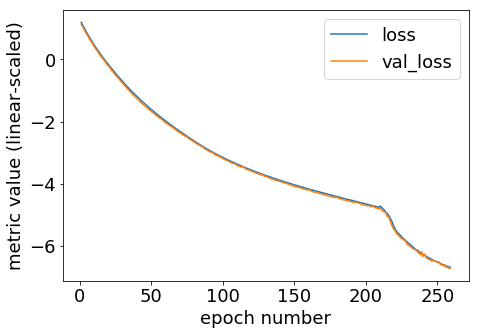

In [34]:
instance.plot_metrics(fnmatch_criteria="*loss", yscale="linear")
# instance.plot_metrics(fnmatch_criteria="*absolute*", yscale="linear")
# instance.plot_metrics(fnmatch_criteria="*r_square*", yscale="linear")

checking results:

In [58]:
signal_jets_norm, data_jets_norm = [
    [train_raw.norm(j.cfilter(signal_norm.headers), **norm_args) for j in jet_table] for jet_table in [signal_jets, data_jets]
]

In [62]:
autoencoder = autoencoder_train.layers[1]
encoder, decoder = autoencoder.layers[1:]

nodenames = ["node {}".format(i+1) for i in range(neck_dim)]
data_reps, signal_reps = (
    utils.data_table(encoder.predict(data_norm.data), headers=nodenames, name="background_reps"),
    utils.data_table(encoder.predict(signal_norm.data), headers=nodenames, name="signal_reps")
)

data_jet_reps, signal_jet_reps = (
    [utils.data_table(encoder.predict(d.data), headers=nodenames, name="jet {} background reps".format(i + 1)) for i,d in enumerate(data_jets_norm)],
    [utils.data_table(encoder.predict(d.data), headers=nodenames, name="jet {} signal reps".format(i + 1)) for i,d in enumerate(signal_jets_norm)],
)

data_table :: plotting distrubution(s) for table(s) ['background_reps', 'signal_reps']


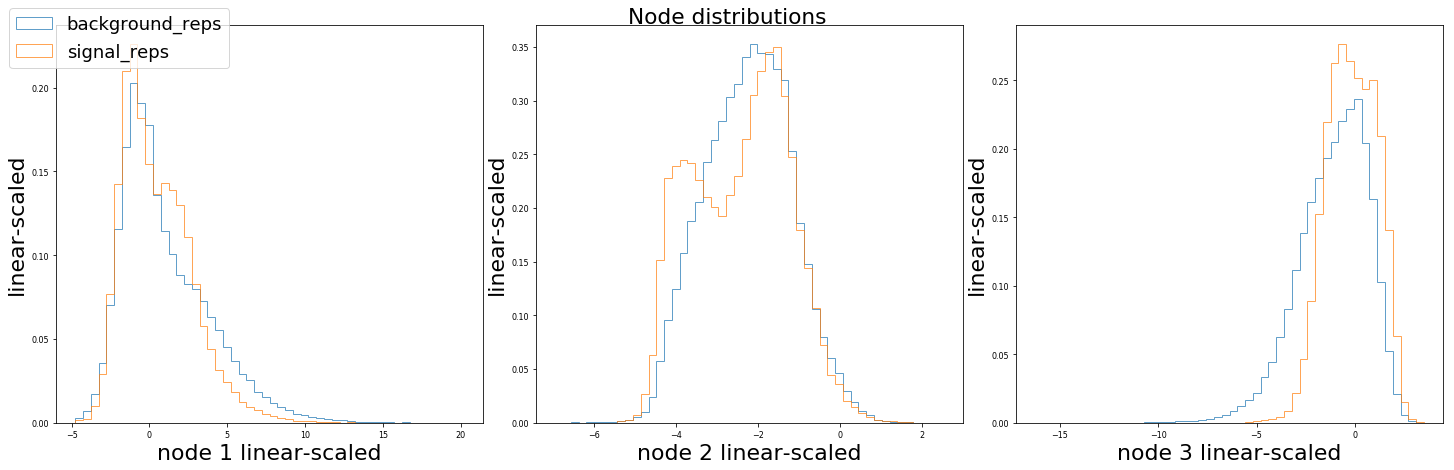

data_table :: plotting distrubution(s) for table(s) ['jet 1 background reps', 'jet 2 background reps', 'jet 1 signal reps', 'jet 2 signal reps']


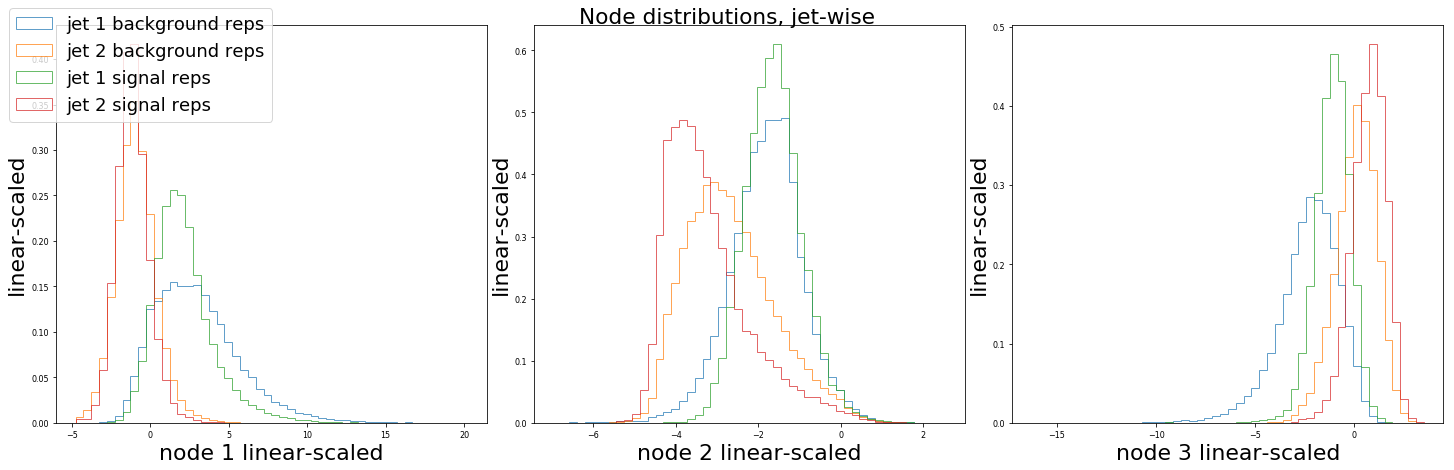

In [65]:
data_reps.plot([signal_reps], cols=5, figsize=20, fontsize=22, normed=1, bins=50, figname="Node distributions", figloc="upper left")
data_jet_reps[0].plot(data_jet_reps[1:] + signal_jet_reps, cols=5, figsize=20, fontsize=22, normed=1, bins=50, figname="Node distributions, jet-wise", figloc="upper left")

In [66]:
data_outputs = autoencoder.predict(data_norm.data)
signal_outputs = autoencoder.predict(signal_norm.data)

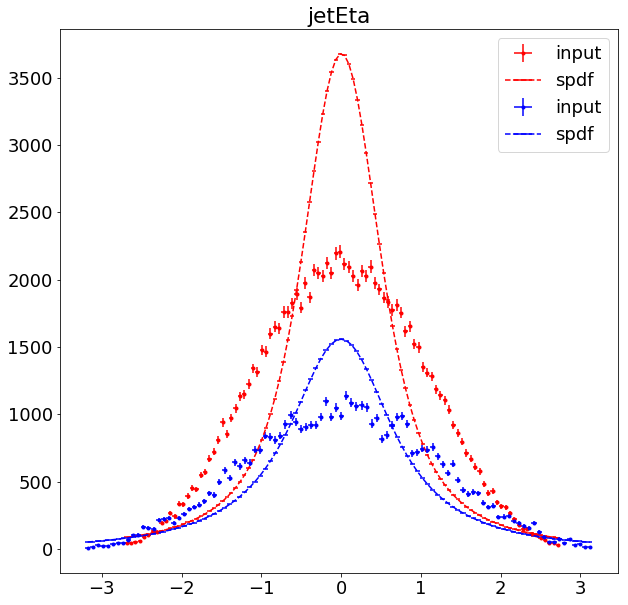

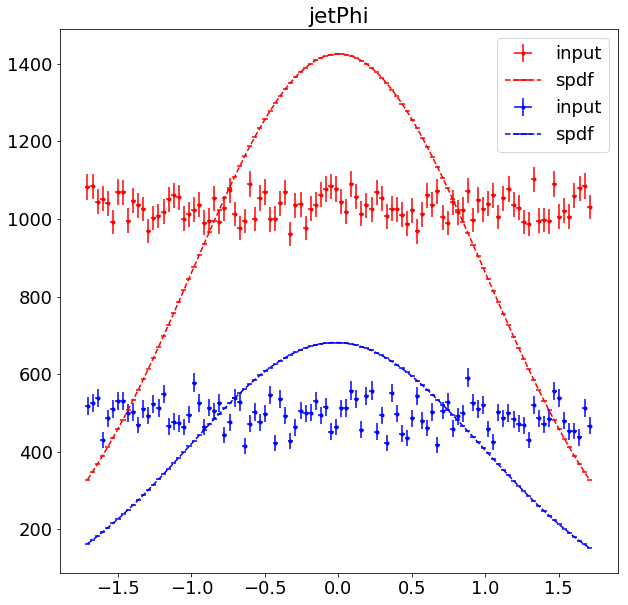

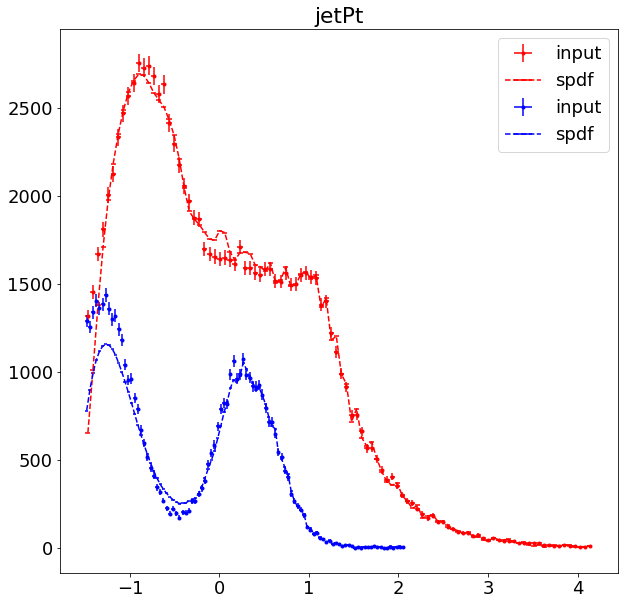

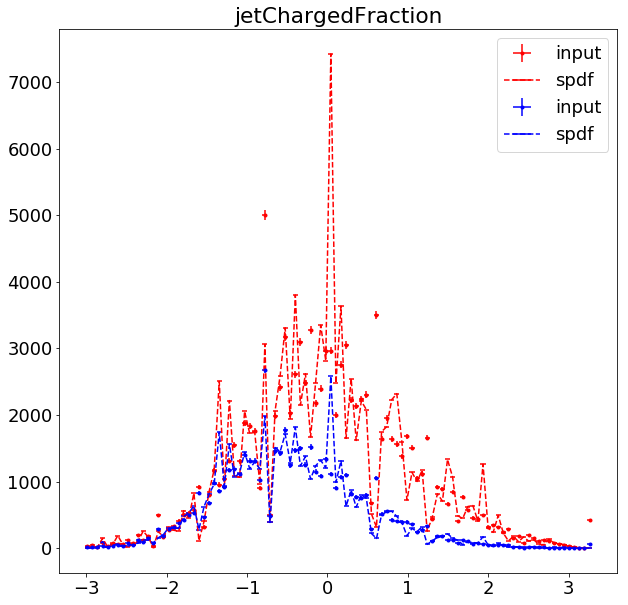

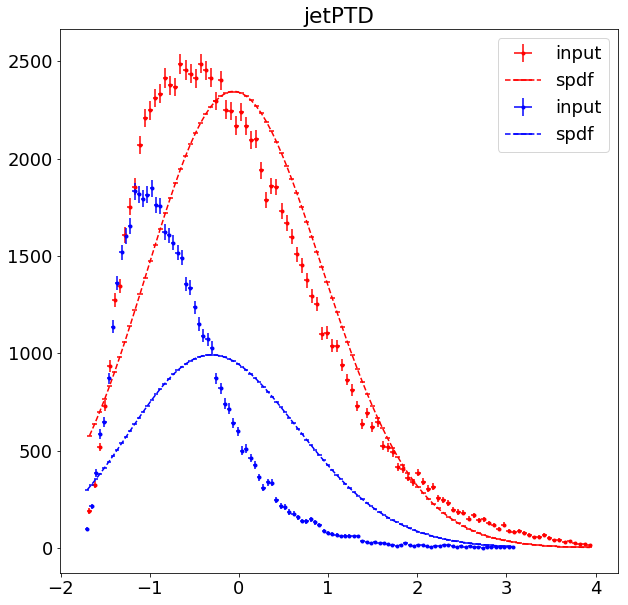

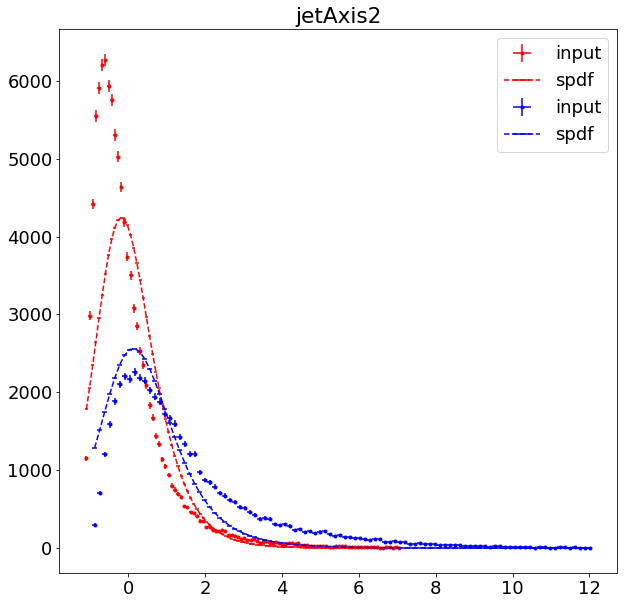

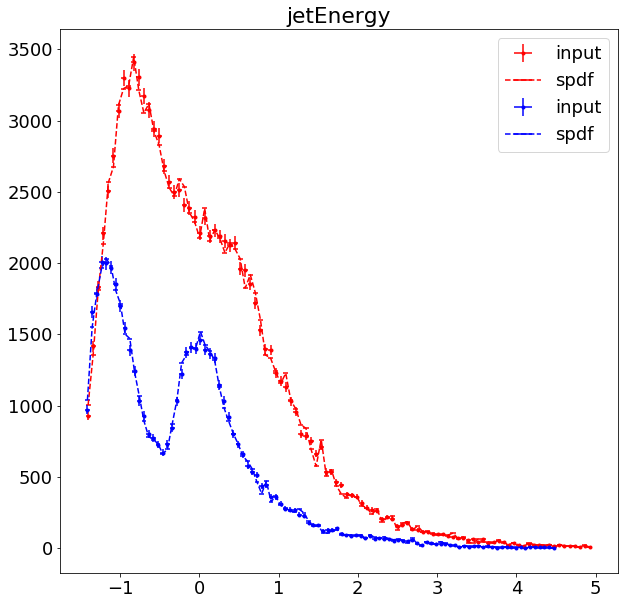

In [14]:
bins = 100

def get_bin_content(aux, mu, sigma, bins=50):
    
    hrange = (np.percentile(aux, 0.1), np.percentile(aux, 99.9))
    
    content, edges = np.histogram(aux, bins=bins, range=hrange)
    centers = 0.5*(edges[1:] + edges[:-1])
    
    width = centers[1] - centers[0]
    
    bin_content = np.sum(content)*width*sum_of_gaussians(centers, mu, sigma)
    
    return centers, (content, bin_content), width

for i,name in enumerate(data_norm.headers):
    plt.figure(figsize=(10,10))

    colors = ['r', 'b']
    for j, (IN, OUT) in enumerate(zip([data_norm.data, signal_norm.data], [data_outputs, signal_outputs])):

        centers, (content, content_new), width = get_bin_content(IN[:,i], OUT[0][:,i], OUT[1][:,i], bins) 

        plt.errorbar(centers, content, xerr=width/2., yerr=np.sqrt(content), fmt='.{}'.format(colors[j]), label='input')
        plt.errorbar(centers, content_new, xerr=width/2., fmt='--{}'.format(colors[j]), label='spdf')
#     plt.hist(mu, histtype='step', bins=bins)
    plt.title(name )
    plt.legend()
    plt.show()

In [80]:
err_data = utils.data_table(np.expand_dims(autoencoder_train.predict(data_norm.data), 1), headers=['loss'], name='data error')
err_signal = utils.data_table(np.expand_dims(autoencoder_train.predict(signal_norm.data), 1), headers=['loss'], name='signal error')
err_data_jets = [
    utils.data_table(
        np.expand_dims(autoencoder_train.predict(d.data), 1),
        headers=['loss'],
        name='jet {} background error'.format(i + 1)
    ) for i,d in enumerate(data_jets_norm)
]

err_signal_jets = [
    utils.data_table(
        np.expand_dims(autoencoder_train.predict(d.data), 1),
        headers=['loss'],
        name='jet {} signal error'.format(i + 1)
    ) for i,d in enumerate(signal_jets_norm)
]

[            loss
 0      -6.589949
 1      -7.915144
 2      -6.538171
 3       2.235472
 4      -8.237504
 5      -3.466950
 6      -6.797215
 7      -7.850312
 8      -5.544733
 9      -9.520073
 10     -2.207748
 11     -9.629119
 12     -8.601812
 13     -1.876779
 14     -7.137841
 15     -8.376154
 16     -8.574966
 17     -7.819184
 18     -7.428110
 19     -6.765238
 20     -6.675227
 21     -7.624301
 22     -8.440209
 23     -7.901164
 24     12.123317
 25     -8.938528
 26     -5.394590
 27     -5.956282
 28     -9.252913
 29     -5.665594
 ...          ...
 51678  -5.647348
 51679  -9.819107
 51680  -6.901424
 51681  -8.336302
 51682  -6.506261
 51683   2.958394
 51684  -5.981590
 51685 -10.625549
 51686  -7.956883
 51687  -5.750811
 51688  -8.155838
 51689  -6.147900
 51690  -5.577542
 51691  -7.965067
 51692  -7.360390
 51693  -3.565344
 51694  -8.410446
 51695  -7.908282
 51696  -1.620450
 51697  -3.837278
 51698  -3.895991
 51699  -9.057457
 51700  -8.676940
 51701  -7

data_table :: plotting distrubution(s) for table(s) ['jet 1 signal error', 'jet 2 signal error', 'jet 1 background error', 'jet 2 background error']


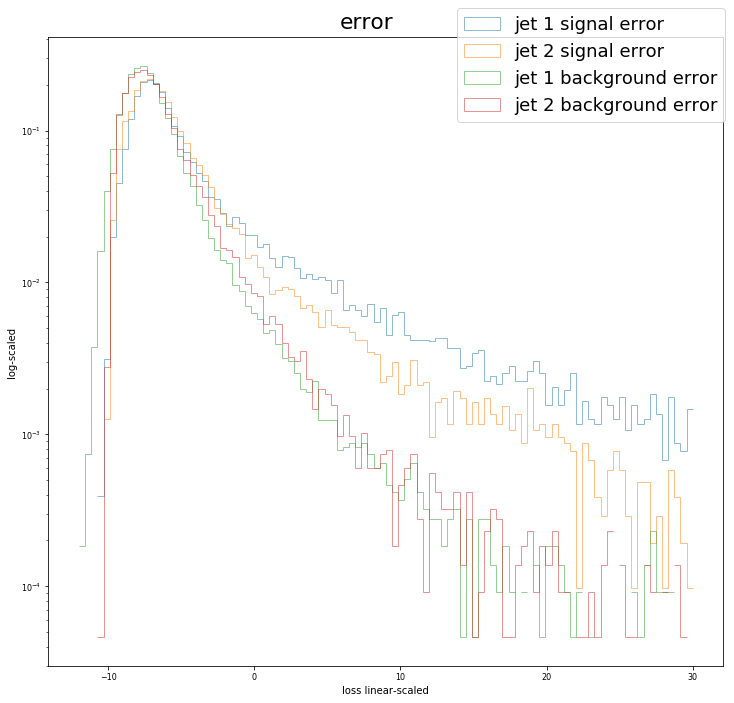

In [81]:
# err_data.plot(
#     err_signal, bins=100, normed=1, yscale='linear',
#     figsize=(10,10), alpha=1.5, rng=(-20,20), 
#     figname="error, signal vs. background"
# )

err_signal_jets[0].plot(
    err_signal_jets[1:] + err_data_jets, bins=100, normed=1, yscale='log',
    figsize=(10,10), alpha=1.5, rng=(-12,30), figloc="upper right",
    figname="error"
)

auc value: 0.685179936385


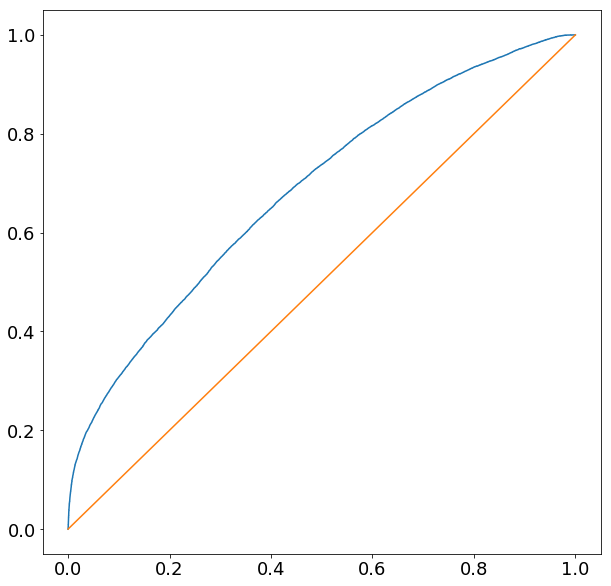

auc value: 0.605480503193


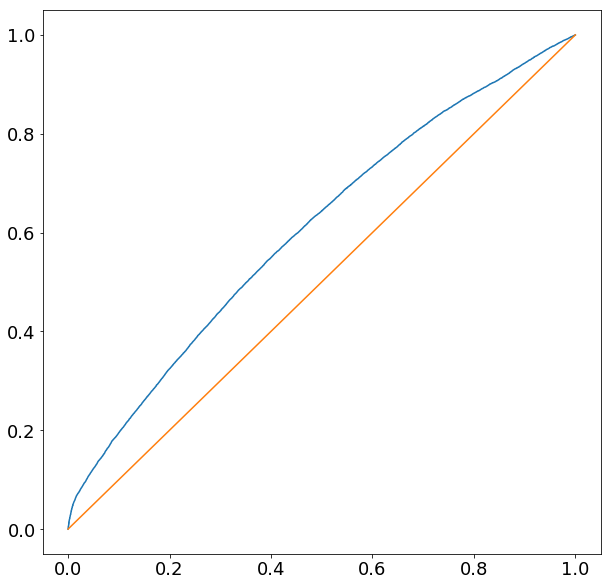

In [75]:
roc_dict_1 = utils.roc_auc_plot(err_data_jets[0], err_signal_jets[0], metric='loss')
roc_dict_2 = utils.roc_auc_plot(err_data_jets[1], err_signal_jets[1], metric='loss')
roc1 = roc_dict_1['roc']
roc2 = roc_dict_2['roc']

In [142]:
def eff_calc(data, signal, percentile):
    threshold = np.percentile(signal, percentile)
    
    dcount = (data > threshold).sum()
    dsignal = (signal > threshold).sum()
    return map(float, [dcount, dsignal, dsignal/dcount])

eff_calc(err_data, err_signal, 90)


[2585.0, 4952.0, 1.9156673114119922]

In [132]:
np.percentile(err_data, (90))

-0.92890298366546631

In [122]:
x,y,val = roc

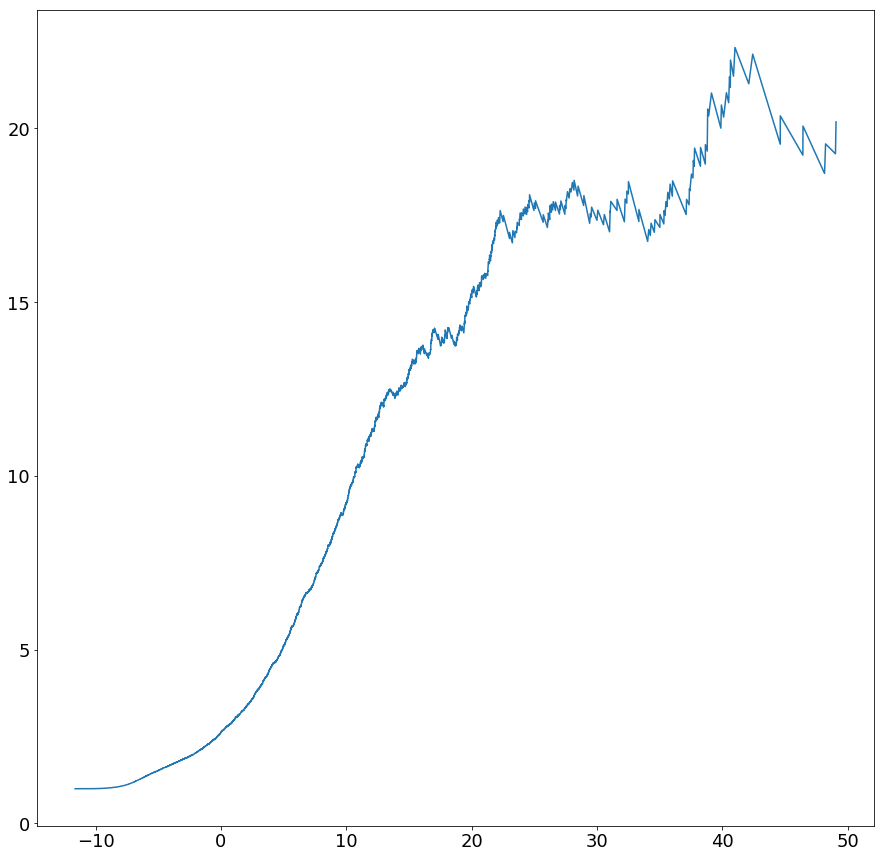

In [125]:
idx = np.where((x > 0.) & (val < 50))
plt.plot(val[idx], (y[idx]/x[idx]))
# plt.yscale("log")
plt.show()